研究的目标是将组织样本分类为良性和恶性（一个二值分类任务）。

为使分类任务可行，研究人员对图像进行了特征提取，正如我们在第4章所做的那样。他们研究了总共569张图像，提取了30种不同的特征，这些特征描述了图像中细胞核的特征，包括以下内容：
- 细胞核结构（用灰度值的标准差表示）。
- 细胞核大小（计算从中心到周边点的距离均值）。
- 组织平滑度（半径长度的局部变化）。
- 组织紧密度。

## 加载数据集

In [1]:
from sklearn import datasets
data = datasets.load_breast_cancer()

In [2]:
# 行表示数据样本，列表示特征值：
data.data.shape

(569, 30)

In [3]:
# 查看提供的特征名称
data.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [4]:
# 因为这是一个二值分类任务，所以我们希望刚好找到两个目标名称：
data.target_names

array(['malignant', 'benign'], dtype='<U9')

In [5]:
# 保留所有数据样本的20%用于测试：
import sklearn.model_selection as ms
X_train, X_test, y_train, y_test = ms.train_test_split(data.data, data.target, test_size=0.2, random_state=42)

## 构建决策树

In [6]:
# 创建一棵决策树：
from sklearn import tree
dtc = tree.DecisionTreeClassifier(random_state=42)

In [7]:
# 使用fit函数来训练决策树：
dtc.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [8]:
# 训练得分与测试得分
dtc.score(X_train, y_train), dtc.score(X_test, y_test)

(1.0, 0.9473684210526315)

因为scikit-learn出色的默认参数值，无须做太多，我们在测试集上就已经实现了94.7%的准确率。但是，有没有可能在测试集上得到更高的得分呢？

为了回答这个问题，我们可以做一些模型探索。例如，我们之前提到的树的高度对树的性能有影响。

重复建立不同max_depth值的树：

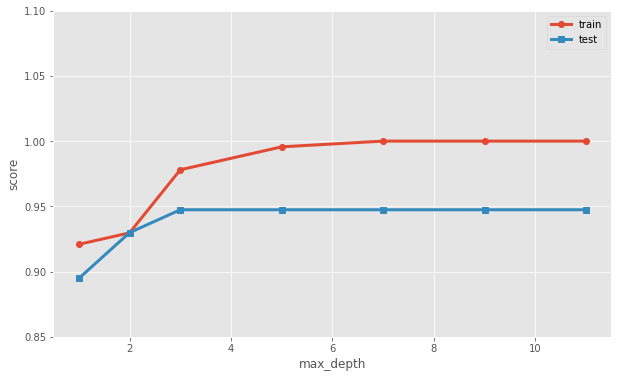

In [9]:
import numpy as np
max_depths = np.array([1, 2, 3, 5, 7, 9, 11])
train_score = []
test_score = []
for d in max_depths:
    dtc = tree.DecisionTreeClassifier(max_depth=d, random_state=42)
    dtc.fit(X_train, y_train)
    train_score.append(dtc.score(X_train, y_train))
    test_score.append(dtc.score(X_test, y_test))
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_score, 'o-', linewidth=3, label='train')
plt.plot(max_depths, test_score, 's-', linewidth=3, label='test')
plt.xlabel('max_depth')
plt.ylabel('score')
plt.ylim(0.85, 1.1)
plt.legend()

现在，树的深度对性能的影响显而易见。似乎树越深，在训练集上的性能就越好。可是，在涉及测试集性能时，情况似乎就有点复杂了。在增加的深度值超过3时，并不能进一步提升测试得分，因此我们仍然停留在94.7%。也许我们可以利用另一种不同的先剪枝设置来得到更好的效果。

让我们再创建一棵树。使一个节点成为叶子节点所需的最小样本数是多少呢？

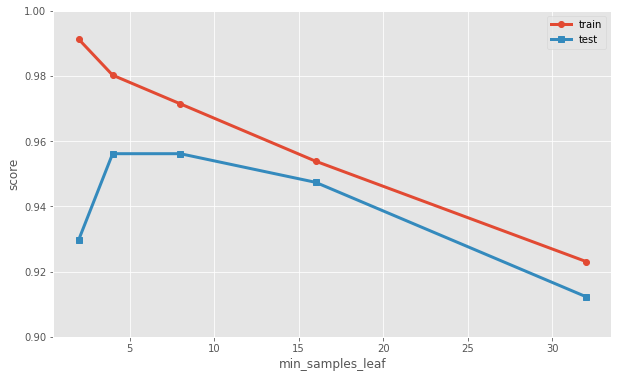

In [10]:
train_score = []
test_score = []
min_samples = np.array([2, 4, 8, 16, 32])
for s in min_samples:
    dtc = tree.DecisionTreeClassifier(min_samples_leaf=s, random_state=42)
    dtc.fit(X_train, y_train)
    train_score.append(dtc.score(X_train, y_train))
    test_score.append(dtc.score(X_test, y_test))
plt.figure(figsize=(10, 6))
plt.plot(min_samples, train_score, 'o-', linewidth=3, label='train')
plt.plot(min_samples, test_score, 's-', linewidth=3, label='test')
plt.xlabel('min_samples_leaf')
plt.ylabel('score')
plt.ylim(0.9, 1)
plt.legend()

很明显，增加min_samples_leaf对训练得分来说并不是好兆头。但这未必就是坏事！因为下面的曲线上出现了一件有趣的事情：在4和8之间测试得分经过最大值，这是到目前为止我们看到的最好的测试得分——95.6%！我们仅通过调整模型参数，就将得分提升了0.9%。